# Explore the Benefits of Rebalancing

In this exercise, we are going to explore the benefits of synthetic rebalancing of heavily imbalanced datasets, where a minority class of interest accounts for less than 0.1% of cases. 

Rebalancing can be useful for cases where we want to learn more of an otherwise small or underrepresented population segment by seeing more examples thereof. Of course, also a synthesizer can only leverage the data that it has seen. But if the method is data-efficient, and in particular more effective than the downstream data consumer, then it is possible to gain a significant advantage by synthetic rebalancing.

<img src='./rebalancing.png' width="600px"/>

In terms of evaluation, we again turn towards the Train-Synthetic-Test-Real approach to benchmark the predictive accuracy of a model that is trained on the (rebalanced) synthetic data, and compare that to a model trained on the (imbalanced) actual data. In addition, we will also benchmark against established methods for rebalancing, like naive upsampling as well as SMOTE. All four models are then evaluated on a holdout data, and compared in terms of predictive performance.

## Synthesize Data via MOSTLY AI

For this tutorial, we will be using again the UCI Adult Income [[1](#refs)] dataset, as well as the same training and validation split, that was used in the Train-Synthetic-Test-Real tutorial. However, we did create an artificial imbalance of 0.1% of low-income records in the training data, by downsampling the minority class. The corresponding preparation script can be found at the end of this notebook.

1. Download `census-training-imbalanced.csv` by clicking [here](https://github.com/mostly-ai/mostly-tutorials/raw/dev/rebalancing/census-training-imbalanced.csv) and pressing Ctrl+S to save the file locally.

2. Synthesize `census-training-imbalanced.csv` via [MOSTLY AI](https://mostly.ai/), configure column `income` as `categorical`, and rebalance it by setting the probability for value `>50K` to 50%. Save the column settings, and then launch the job.

<img src='./screen1.png' width="600px"/>

3. Once the job has finished, download the generated synthetic data as CSV file to your computer. Optionally, you can alsodownload a previously synthesized version [here](https://github.com/mostly-ai/mostly-tutorials/raw/dev/rebalancing/census-synthetic-balanced.csv).

4. Upload the generated synthetic data to this Notebook via executing the next cell.

In [1]:
# upload synthetic dataset
import pandas as pd
try:
    # check whether we are in Google colab
    from google.colab import files
    print("running in COLAB mode")
    repo = 'https://github.com/mostly-ai/mostly-tutorials/raw/dev/rebalancing'
    import io
    uploaded = files.upload()
    syn = pd.read_csv(io.BytesIO(list(uploaded.values())[0]))
    print(f"uploaded synthetic data with {syn.shape[0]:,} records and {syn.shape[1]:,} attributes")
except:
    print("running in LOCAL mode")
    repo = '.'
    print("adapt `syn_file_path` to point to your generated synthetic data file")
    syn_file_path = './census-synthetic-balanced.csv'
    syn = pd.read_csv(syn_file_path)
    print(f"read synthetic data with {syn.shape[0]:,} records and {syn.shape[1]:,} attributes")
    
trn = pd.read_csv(f'{repo}/census-training-imbalanced.csv')
print(f'read training data with {trn.shape[0]:,} records and {trn.shape[1]} attributes')

running in LOCAL mode
adapt `syn_file_path` to point to your generated synthetic data file
read synthetic data with 29,753 records and 15 attributes
read training data with 29,753 records and 15 attributes


## Explore Synthetic Data

### Samples Random Records

Let's first show 10 randomly sampled original records, from the imbalanced dataset. Try executing the cell multiple times, to see different samples. Still, due to the strong imbalance, you will hardly ever encounter a sample of the high income class (i.e. `income` being `>50K`).

In [2]:
trn.sample(n=10)

age  workclass  fnlwgt     education  education_num  \
26781   38  State-gov  341643    Assoc-acdm             12   
20028   25    Private  181054     Bachelors             13   
5340    41    Private  222142       HS-grad              9   
705     23    Private  239375     Bachelors             13   
29569   29    Private  289991       HS-grad              9   
7205    23    Private   54472  Some-college             10   
12449   23          ?  381741    Assoc-acdm             12   
3455    46    Private  102542       7th-8th              4   
13088   57    Private  116878       1st-4th              2   
23156   43    Private   33126  Some-college             10   

              marital_status         occupation   relationship   race     sex  \
26781          Never-married    Exec-managerial  Not-in-family  White    Male   
20028          Never-married              Sales  Not-in-family  White  Female   
5340      Married-civ-spouse  Machine-op-inspct        Husband  White    Male   
705            Never-married  Machine-op-inspct      Own-child  White    Male   
29569          Never-married   Transport-moving      Unmarried  White    Male   
7205   Married-spouse-absent      Other-service  Not-in-family  White  Female   
12449          Never-married                  ?      Own-child  White    Male   
3455           Never-married      Other-service      Own-child  White    Male   
13088     Married-civ-spouse  Handlers-cleaners        Husband  White    Male   
23156     Married-civ-spouse    Exec-managerial        Husband  White    Male   

       capital_gain  capital_loss  hours_per_week native_country income  
26781             0             0              60  United-States  <=50K  
20028             0             0              40  United-States  <=50K  
5340              0             0              40  United-States  <=50K  
705               0             0              40  United-States  <=50K  
29569             0             0              55  United-States  <=50K  
7205              0             0              50  United-States  <=50K  
12449             0          1721              20  United-States  <=50K  
3455              0             0              52  United-States  <=50K  
13088             0             0              40          Italy  <=50K  
23156             0             0              50  United-States  <=50K

Let's now display 10 randomly sampled synthetic records. Again, run the cell multiple times. This time, you should see that the records are evenly distributed across the two `income` classes.

In [3]:
syn.sample(n=10)

age  workclass  fnlwgt     education  education_num  \
3295    42    Private  181984  Some-college             10   
5878    23    Private  106626  Some-college             10   
21761   56    Private  118480       HS-grad              9   
5360    31    Private  434640       5th-6th              3   
16914   39    Private  170935  Some-college             10   
513     37    Private  298350       HS-grad              9   
28023   68    Private  188252  Some-college             10   
25978   36  Local-gov   37278       Masters             14   
8704    28    Private  388361  Some-college             10   
26846   47          ?   95111       7th-8th              4   

              marital_status         occupation   relationship  \
3295           Never-married       Adm-clerical  Not-in-family   
5878           Never-married    Farming-fishing  Not-in-family   
21761                Widowed  Machine-op-inspct      Unmarried   
5360   Married-spouse-absent      Other-service      Own-child   
16914     Married-civ-spouse       Craft-repair        Husband   
513            Never-married   Transport-moving      Unmarried   
28023               Divorced     Prof-specialty  Not-in-family   
25978          Never-married     Prof-specialty  Not-in-family   
8704      Married-civ-spouse  Machine-op-inspct        Husband   
26846               Divorced                  ?  Not-in-family   

                     race     sex  capital_gain  capital_loss  hours_per_week  \
3295                White  Female             0             0              40   
5878   Amer-Indian-Eskimo    Male             0             0              45   
21761               White  Female             0             0              27   
5360                White    Male             0             0              32   
16914               White    Male             0             0              40   
513                 White  Female             0             0              45   
28023               White  Female             0             0              40   
25978               Black    Male             0             0              20   
8704                Black    Male             0             0              40   
26846               Other  Female             0             0              40   

      native_country income  
3295   United-States   >50K  
5878   United-States  <=50K  
21761  United-States   >50K  
5360          Mexico   >50K  
16914  United-States   >50K  
513    United-States  <=50K  
28023  United-States  <=50K  
25978  United-States   >50K  
8704   United-States   >50K  
26846  United-States   >50K

### Sample Female Doctors with a High Income

Let's now investigate all female doctors with a high income. But, it turns out there are actually none in the original data, thus we won't be able to learn anything.

In [4]:
trn[(trn['income']=='>50K') & (trn.sex=='Female') & (trn.education=='Doctorate')]

Empty DataFrame
Columns: [age, workclass, fnlwgt, education, education_num, marital_status, occupation, relationship, race, sex, capital_gain, capital_loss, hours_per_week, native_country, income]
Index: []

However, the synthetic data does contain a list of realistic, statistically sound female doctors with a high income, that allow to learn about this particular subsegment.

In [5]:
syn[(syn['income']=='>50K') & (syn.sex=='Female') & (syn.education=='Doctorate')].sample(n=10)

age         workclass  fnlwgt  education  education_num  \
5361    48       Federal-gov   78399  Doctorate             16   
22378   30           Private  128709  Doctorate             16   
2494    31           Private   49763  Doctorate             16   
26183   44  Self-emp-not-inc  156754  Doctorate             16   
26166   38         Local-gov  187293  Doctorate             16   
10206   39         State-gov  144622  Doctorate             16   
20955   39         State-gov  107394  Doctorate             16   
18218   53           Private  178032  Doctorate             16   
8627    40  Self-emp-not-inc   47385  Doctorate             16   
26283   31           Private  281303  Doctorate             16   

           marital_status       occupation   relationship                race  \
5361            Separated   Prof-specialty      Unmarried               Black   
22378       Never-married   Prof-specialty  Not-in-family               White   
2494   Married-civ-spouse   Prof-specialty           Wife  Asian-Pac-Islander   
26183  Married-civ-spouse  Exec-managerial           Wife               White   
26166       Never-married   Prof-specialty      Own-child               White   
10206       Never-married   Prof-specialty  Not-in-family               White   
20955            Divorced   Prof-specialty      Own-child  Asian-Pac-Islander   
18218       Never-married   Prof-specialty      Unmarried  Amer-Indian-Eskimo   
8627             Divorced   Prof-specialty  Not-in-family               White   
26283  Married-civ-spouse   Prof-specialty           Wife               Black   

          sex  capital_gain  capital_loss  hours_per_week native_country  \
5361   Female             0             0               8  United-States   
22378  Female             0          1876              70  United-States   
2494   Female             0             0              70  United-States   
26183  Female             0             0              60  United-States   
26166  Female             0             0              15  United-States   
10206  Female             0             0              40  United-States   
20955  Female             0             0              20  United-States   
18218  Female          3325             0              45  United-States   
8627   Female             0             0              40  United-States   
26283  Female             0             0              30  United-States   

      income  
5361    >50K  
22378   >50K  
2494    >50K  
26183   >50K  
26166   >50K  
10206   >50K  
20955   >50K  
18218   >50K  
8627    >50K  
26283   >50K

## Compare ML Performance via TSTR

In [6]:
import lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

target_col = 'income'
target_val = '>50K'

def prepare_xy(df: pd.DataFrame):
    y = (df[target_col]==target_val).astype(int)
    str_cols = [col for col in df.select_dtypes(['object', 'string']).columns if col != target_col]
    for col in str_cols:
        df[col] = pd.Categorical(df[col])
    cat_cols = [col for col in df.select_dtypes('category').columns if col != target_col]
    num_cols = [col for col in df.select_dtypes('number').columns if col != target_col]
    for col in num_cols:
        df[col] = df[col].astype('float')
    X = df[cat_cols + num_cols]
    return X, y

def train_model(X, y):
    cat_cols = list(X.select_dtypes('category').columns)
    X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
    ds_trn = lgb.Dataset(X_trn, label=y_trn, categorical_feature=cat_cols, free_raw_data=False)
    ds_val = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_cols, free_raw_data=False)
    model = lgb.train(
        params={
            'verbose': -1,
            'metric': 'auc',  
            'objective': 'binary'
        }, 
        train_set=ds_trn,
        valid_sets=[ds_val],
        callbacks=[early_stopping(5)],
    )
    return model

def evaluate_model(model, hol):
    X_hol, y_hol = prepare_xy(hol)
    probs = model.predict(X_hol)
    preds = (probs >= 0.5).astype(int)
    auc = roc_auc_score(y_hol, probs)
    f1 = f1_score(y_hol, probs>0.5, average='macro')
    probs_df = pd.concat([
        pd.Series(probs, name='probability').reset_index(drop=True),
        pd.Series(y_hol, name=target_col).reset_index(drop=True)
    ], axis=1)
    sns.displot(data=probs_df, x='probability', hue=target_col, bins=20, multiple="stack")
    plt.title(f"AUC: {auc:.1%}, F1 Score: {f1:.2f}", fontsize = 20)
    plt.show()
    return auc

import warnings
warnings.filterwarnings('ignore')

In [7]:
df_hol = pd.read_csv(f'{repo}/census-holdout.csv')
df_hol_min = df_hol.loc[df_hol['income']=='>50K']
print(f"Holdout data consists of {df_hol.shape[0]:,} records",
      f"with {df_hol_min.shape[0]:,} samples from the minority class")

Holdout data consists of 9,768 records with 2,337 samples from the minority class


### Train model on the original imbalanced training data

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.320482


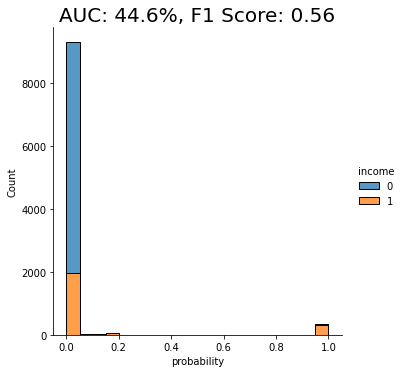

In [8]:
X_trn, y_trn = prepare_xy(trn)
model_trn = train_model(X_trn, y_trn)
auc_trn = evaluate_model(model_trn, df_hol)

With an AUC of about 50%, the model trained on the imbalanced dataset is just as good as a flip of a coin. I.e., the downstream LightGBM model is not able to learn any signal due to the low number of samples.

### Train model on naively rebalanced training data

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[50]	valid_0's auc: 1


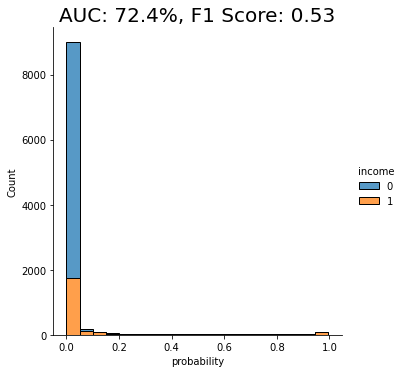

In [9]:
from imblearn.over_sampling import RandomOverSampler
X_trn, y_trn = prepare_xy(trn)
sm = RandomOverSampler(random_state=1)
X_trn_up, y_trn_up = sm.fit_resample(X_trn, y_trn)
model_trn_up = train_model(X_trn_up, y_trn_up)
auc_trn_up = evaluate_model(model_trn_up, df_hol)

Random "naive" upsampling [[2](#refs)], which simply adds minority samples multiple times to achieve a balance, only marginally helps the downstream model in this case.

### Train model on SMOTE rebalanced training data

SMOTE upsampling [[3](#refs)], which creates novel (non-privacy-preserving) samples by interpolating between neighboring samples, does boost the performance of the downstream model to close to 80%.

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[36]	valid_0's auc: 0.999947


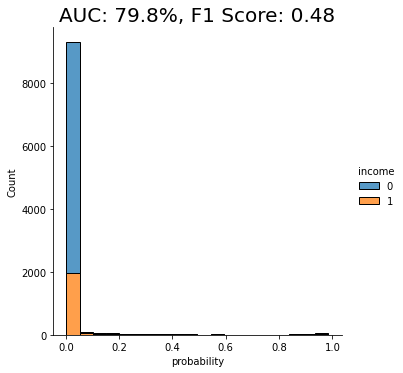

In [10]:
from imblearn.over_sampling import SMOTENC
X_trn, y_trn = prepare_xy(trn)
sm = SMOTENC(categorical_features=X_trn.dtypes=='category', random_state=1)
X_trn_smote, y_trn_smote = sm.fit_resample(X_trn, y_trn)
model_trn_smote = train_model(X_trn_smote, y_trn_smote)
auc_trn_smote = evaluate_model(model_trn_smote, df_hol)

### Train model on balanced synthetic data

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[74]	valid_0's auc: 0.84403


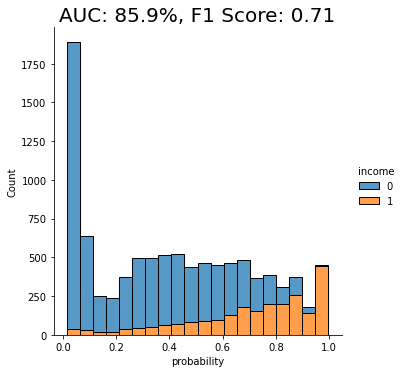

In [11]:
X_syn, y_syn = prepare_xy(syn)
model_syn = train_model(X_syn, y_syn)
auc_syn = evaluate_model(model_syn, df_hol)

Both, performance measures, the AUC [[4](#refs)] as well as the macro-averaged F1 score [[5](#refs)] are significantly better for the model that was trained on synthetic data, than if it were trained on any of the other methods. This is a strong proof of value of synthetic rebalancing for learning more about a small sub-group within the population.

## Conclusion

For the given dataset and the given synthesizer we can see, that both data analysts as well as AI engineers can learn more from a balanced synthetic dataset when compared to the imbalanced original dataset. Note, that the actual lift in performance may vary, depending on the dataset, the predictive task, and the chosen ML model.

## Further exercises

In addition to walking through the above instructions, we suggest..
* to repeat the experiments for different class imbalances - see the helper script at the bottom to create such experiments
* to repeat the experiments for different datasets, ML models, etc.

## References<a class="anchor" name="refs"></a>

1. https://archive.ics.uci.edu/ml/datasets/adult
1. https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html
1. https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTENC.html
1. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
1. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

## Extras - Data Preparation

The following code snippet can be used to create an artificially imbalanced training dataset.

In [12]:
def create_imbalance(df, target, ratio):
    val_min, val_maj = df[target].value_counts().sort_values().index
    df_maj = df.loc[df[target]==val_maj]
    n_min = int(df_maj.shape[0]/(1-ratio)*ratio)
    df_min = df.loc[df[target]==val_min].sample(n=n_min, random_state=1)
    df_maj = df.loc[df[target]==val_maj]
    df_imb = pd.concat([df_min, df_maj]).sample(frac=1, random_state=1)
    return df_imb

df_trn = pd.read_csv(f'{repo}/census-training.csv')
df_trn_imb = create_imbalance(df_trn, 'income', 1/1000)
df_trn_imb.to_csv('census-training-imbalanced.csv', index=False)